# Geochemical Estimates of 20th Century Acidification in the Salish Sea
### Figure Content:
 - **Extended Data Figure 3:** Centennial changes in $p$CO$_2$ and pH in the Salish Sea
 ---------

In [1]:
import sys
import os
import importlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import math
from scipy import optimize

import warnings
warnings.filterwarnings('ignore')

Import functions to clean up model output and locate coral sites

In [2]:
sys.path.insert(1, '../Functions')

import WOAC_Functions_Manuscript as WOAC_fxns
importlib.reload(WOAC_fxns)

<module 'WOAC_Functions_Manuscript' from '/raid/mmstoll/Code/Industrial_Era_OA_Code/../Functions/WOAC_Functions_Manuscript.py'>

# Open files

In [3]:
file_coral_d11B_info = '/home/mmstoll/raid/Data/Coral_Data/BGC_Model_Coral_d11B_Data.csv'
file_SalishSea_obs_data = '/home/mmstoll/raid/Data/Coral_Data/WOAC_DIC_Alk_pH_data_Mary_Margaret_Stoll_2008-2018.xlsx'
file_upwelling_properties = '/home/mmstoll/raid/Data/Coral_Data/Upwelling_Properties.csv'

In [4]:
compiled_d11B_data = pd.read_csv(file_coral_d11B_info)
compiled_d11B_data = compiled_d11B_data.loc[:, ~compiled_d11B_data.columns.str.contains('^Unnamed')]
compiled_d11B_data = compiled_d11B_data.dropna()

Historic and modern coral skeletal d11B data from the Salish Sea

In [5]:
SS_d11B_hist = compiled_d11B_data.loc[(compiled_d11B_data['Salish_vs_West_Coast'] == 'Salish Sea') & (compiled_d11B_data['Historic_vs_Modern'] == 'Historic')]
SS_d11B_mod = compiled_d11B_data.loc[(compiled_d11B_data['Salish_vs_West_Coast'] == 'Salish Sea') & (compiled_d11B_data['Historic_vs_Modern'] == 'Modern')]

Observational bottle data from the Salish Sea collected by the Washington Ocean Acidification Center

In [6]:
SS_obs = pd.read_excel(file_SalishSea_obs_data, engine = 'openpyxl')
SS_obs = SS_obs[(SS_obs['DIC_UMOL_KG'].notna()) & (SS_obs['pHTOTAL'].notna())]

Modern oceanographic properties of the California Current water mass that upwells and enters the Strait of Juan de Fuca
 - 7-year average from modern model simulation 2000-2007
 - 60 km x 60 km area
 - Depth = 150 - 200m

In [7]:
upwelling_properties = pd.read_csv(file_upwelling_properties, index_col=[0])

# Calculate coral-based $\Delta$pH  and $\Delta$$p$CO$_2$ in the Salish Sea

### Calculate WOAC bottle data averages at Admiralty Inlet (station 21)

In [8]:
def f_tot(temp,sal,DIC,Alk):
    TK = temp + 273.15 #temperature in Celsius into Kelvin	
    I = 19.924*sal/(1000 - 1.0049 * sal) #molal ionic strength
    R = 83.131 #Gas constant (units? cm^3 bar mol-1 deg-1)
    
    #Conservative seawater components as a function of salinity
    B_T = 0.000416 * sal / 35 #total boron
    F_T = 7e-5 * sal / 35 #total HF and F-
    # SO4_T = .0293*Sal/35 #total sulfate species from Millero 1995
    SO4_T = .02824 * sal / 35 #total sulfate species from DOE 1994, and Dickson/Millero's refitting of Mehrbach
    Ca_T = .01028 * sal / 35

    #1st dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)
    tempA = -0.011555 * sal + 0.0001152 * sal**2
    pK1_star = -61.2172 + tempA + 3633.86/TK + 9.6777*math.log(TK)
    K_1_star = 10**(-1*pK1_star)
    K_1 = K_1_star

    #2nd dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)    
    tempA = -.01781*sal + 0.0001122*sal**2
    pK2_star = 471.78/TK + 25.9290 + tempA - 3.16967*math.log(TK)
    K_2_star = 10**(-1*pK2_star)
    K_2 = K_2_star

    #dissociation contant for H2O as recommended by DOE (1994)
    #Total Scale
    temp1 = 148.96502-13847.26/TK-23.6521*math.log(TK)
    temp2 = (118.67/TK-5.977+1.0495*math.log(TK))*math.sqrt(sal)-0.01615*sal
    K_W_star = math.exp(temp1 + temp2)
    pKW_star =-1*math.log(K_W_star,10)
    K_W = K_W_star

    #Boric Acid
    #as reported in Millero 1995 
    #from Dickson Deep-Sea Res 1990 (Roy 1993 agrees)
    #both are in synthetic seawater without F-
    temp1 = (-8966.90-2890.53*math.sqrt(sal)-77.942*sal+1.728*(sal**(3/2))-0.0996*(sal**2))/TK
    temp2 = 148.0248+137.1942*math.sqrt(sal)+1.62142*sal
    temp3 = -math.log(TK)*(24.4344+25.085*math.sqrt(sal)+0.2474*sal)+0.053105*math.sqrt(sal)*TK
    K_B_star = math.exp(temp1+temp2+temp3)
    pKB_star =-1*math.log(K_B_star,10)
    K_B = K_B_star

    
    def f_zero(x):
        denom = (x**2+K_1*x+K_1*K_2)
        Alpha0 = (x**2)/denom
        Alpha1 = (K_1*x)/denom
        Alpha2 = (K_1*K_2)/denom
    
        return((Alpha1*DIC) + (2*Alpha2*DIC) + (K_W/x) + (B_T/(1+x/K_B)) - Alk - x) #equation that equals 0
    
    root = optimize.bisect(f_zero,1*10**-16,1) #calculates root of the equation returned by f_zero
    ph_value = (-math.log(root,10)) #calculates and returns the pH values
    return(ph_value)

In [9]:
stn_21_obs = SS_obs.loc[SS_obs['STN'] == 21] #WOAC station 21 is closest to Admiralty Inlet, where a majority of Salish Sea corals are located
stn_21_obs = stn_21_obs.loc[(SS_obs['MONTH'] == 7) & (SS_obs['PRESS (dbar)'] >50)] #Select July data at a depth > 50dbar, where corals reside

summ_temp_obs = stn_21_obs['TEMP (C, ITS-90)'].mean()
summ_sal_obs = stn_21_obs['SAL (PSS-78)'].mean()
summ_DIC_obs = stn_21_obs['DIC_UMOL_KG'].mean()/(1*10**6)
summ_TA_obs = stn_21_obs['TA_UMOL_KG'].mean()/(1*10**6)
summ_pH_obs =  f_tot(summ_temp_obs, summ_sal_obs, summ_DIC_obs, summ_TA_obs) #total scale

In [10]:
indices = ['summer_avg']
columns = ['DIC_avg', 'pH_avg', 'alk_avg','temp_avg', 'sal_avg']
seasonal_avgs = pd.DataFrame(index=indices, columns=columns)

In [11]:
seasonal_avgs.at['summer_avg','DIC_avg'] = (summ_DIC_obs) * 10**6
seasonal_avgs.at['summer_avg','pH_avg'] = (summ_pH_obs)
seasonal_avgs.at['summer_avg','alk_avg'] = (summ_TA_obs) * 10**6
seasonal_avgs.at['summer_avg','temp_avg'] = (summ_temp_obs)
seasonal_avgs.at['summer_avg','sal_avg'] = (summ_sal_obs)

In [12]:
#Values from WOAC station 21 Supplement Table 2.1; annual averages of seasonal fitted curve
annual_avg_ph = 7.73 #total scale
annual_avg_DIC = 2116 #umol/kg

### Calculate pH value for every skeletal $\delta$$^1$$^1$B sample
 - $\delta$$^1$$^1$B - pH relationship detailed in Methods

In [13]:
SS_hist_DIC = 2093 #umol/kg, summertime historic estimate of DIC at Admiralty Inlet (Feely et al. 2010)
SS_mod_DIC = float(seasonal_avgs['DIC_avg']) #umol/kg, summertime modern average of bottle data at WOAC Station 21 near Admiralty Inlet >50m depth

In [14]:
SS_d11B_hist_DIC_correction = ((SS_hist_DIC - 2500)/1000)*1.08 
SS_d11B_mod_DIC_correction = ((SS_mod_DIC - 2500)/1000)*1.08
SS_d11B_hist.loc[:,'d11B_DIC_corrected'] = SS_d11B_hist['d11B'] + SS_d11B_hist_DIC_correction
SS_d11B_mod.loc[:,'d11B_DIC_corrected'] = SS_d11B_mod['d11B'] + SS_d11B_mod_DIC_correction

In [15]:
#Transform d11B data into pH (total scale)
SS_d11B_hist.loc[:,'pH_Tot'] = (SS_d11B_hist['d11B_DIC_corrected']+ 9.896) / 4.328
SS_d11B_mod.loc[:,'pH_Tot'] = (SS_d11B_mod['d11B_DIC_corrected']+ 9.896) / 4.328

The modern WOAC observational data provides additional information that we can use to better calibrate our proxy and to estimate ΔpH for the Salish Sea. Comparing modern observational DIC and pH data (red circle, Extended Data Figure 3, Supplement 2.2) to modern δ11B (grey line, Extended Data Figure 3), we found that a pH offset of -0.10 was necessary to align the two datasets. We attribute this difference to culture conditions not exactly matching the natural wild coral setting. To calibrate the coral data, we apply this pH offset of -0.10 to all our coral data, including our historic and modern records from the Salish Sea and historic records from the US West Coast. This offset does not impact the interpretation of data from the Salish Sea where we have historic-modern pairs, but applying this same offset to all coral samples anchors the historical West Coast coral data so they can be accurately compared to modeled historic values and other proxies. 

In [16]:
offset = round(SS_d11B_mod['pH_Tot'].mean() - float(seasonal_avgs['pH_avg']),3)

In [17]:
#Add pH offset to coral data
SS_d11B_hist.loc[:,'pH_Tot_Summ_Offset'] = (SS_d11B_hist['pH_Tot'] - offset)
SS_d11B_mod.loc[:,'pH_Tot_Summ_Offset'] = (SS_d11B_mod['pH_Tot']- offset)

### Calculate $p$CO$_2$ value for every skeletal $\delta$$^1$$^1$B sample

Solver function to calculate $p$CO$_2$ from pH, DIC, temperature and salinity
 - **pH:**
   - Calculated from skeletal $\delta$$^1$$^1$B data and $\delta$$^1$$^1$B - pH relationship, detailed in Methods
 - **DIC:**
   - Historic: Summertime estimate of historic DIC at Admiralty Inlet (Feely et al. 2010)
   - Modern: Summertime average of bottle data at WOAC Station 21 near Admiralty Inlet > 50m depth
 - **Temperature:**
   - Summertime average of bottle data at WOAC Station 21 near Admiralty Inlet > 50m depth 
 - **Salinity:**
   - Summertime average of bottle data at WOAC Station 21 near Admiralty Inlet > 50m depth
   
*We assume that temperature and salinity remained constant over the past century. Realistic sensitivty analyses of change over the past century have little to no effect on the results. More details on the WOAC Station 21 data can be found in Supplementary Info Table 2.1.*

In [18]:
def calc_pCO2(ph, DIC, temp, sal):
    root = 10**-ph
    TK = temp + 273.15 #temperature in Celsius into Kelvin

    #1st dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)
    tempA = -0.011555 * sal + 0.0001152 * sal**2
    pK1_star = -61.2172 + tempA + 3633.86/TK + 9.6777*math.log(TK)
    K_1_star = 10**(-1*pK1_star)
    K_1 = K_1_star

    #2nd dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)    
    tempA = -.01781*sal + 0.0001122*sal**2
    pK2_star = 471.78/TK + 25.9290 + tempA - 3.16967*math.log(TK)
    K_2_star = 10**(-1*pK2_star)
    K_2 = K_2_star

    denom = (root**2 + K_1*root + K_1*K_2)
    bicarbonate = DIC*10**6*K_1*root / denom
    carbonate = DIC*10**6*K_1*K_2 / denom
    CO2_star = (root*bicarbonate)/K_1

    K_0 = math.exp(93.4517*(100/(temp+273.15)) - 60.2409 + 23.3585*math.log((temp+273.15)/100)+sal*(0.023517-0.023656*((temp+273.15)/100)+0.0047036*((temp+273.15)/100)**2))

    pCO2 = CO2_star / K_0
    
    return(pCO2)

In [19]:
pCO2_hist_array = []
for i in range(0,len(SS_d11B_hist['d11B'])):
    ph_value = SS_d11B_hist['pH_Tot_Summ_Offset'].iloc[i]
    DIC_hist = SS_hist_DIC/(10**6) #units mol/kg
    temp_hist = 9.3 #units C
    sal_hist = 31.8 #units PSU
    pCO2_hist = calc_pCO2(ph_value, DIC_hist, temp_hist, sal_hist)
    pCO2_hist_array.append(float(pCO2_hist))
SS_d11B_hist.loc[:,'pCO2'] = pCO2_hist_array

In [20]:
pCO2_mod_array = []
for i in range(0,len(SS_d11B_mod['d11B'])):
    ph_value = SS_d11B_mod['pH_Tot_Summ_Offset'].iloc[i]
    DIC_mod = SS_mod_DIC/(10**6) #units mol/kg
    temp_mod = 9.3 #units C
    sal_mod = 31.8 #units PSU
    pCO2_mod = calc_pCO2(ph_value, DIC_mod, temp_mod, sal_mod)
    pCO2_mod_array.append(float(pCO2_mod))
SS_d11B_mod.loc[:,'pCO2'] = pCO2_mod_array

#### Calculate $\Delta$pH and $\Delta$$p$CO$_2$ in the Salish Sea 

Coral-based estimate of $\Delta$$p$CO$_2$

In [21]:
delta_pCO2 = SS_d11B_mod['pCO2'].mean() - SS_d11B_hist['pCO2'].mean()
print('The coral-based estimate of delta pCO2 in the Salish Sea over the 20th century = '+str(int(delta_pCO2)) +' uatm.')

The coral-based estimate of delta pCO2 in the Salish Sea over the 20th century = 172 uatm.


Standard error of the difference between means ($\Delta$$p$CO$_2$)

In [22]:
#Standard error modern SS coral data
SD_mod = np.std(SS_d11B_mod['pCO2'])
SE_mod = SD_mod/(np.sqrt(SS_d11B_mod['pCO2'].count()))

In [23]:
#Standard error historic SS coral data
SD_hist = np.std(SS_d11B_hist['pCO2'])
SE_hist = SD_hist/(np.sqrt(SS_d11B_hist['pCO2'].count()))

In [24]:
SE_diff = np.sqrt(SE_mod**2 + SE_hist**2)
print('The standard error of the difference between means (delta pCO2) = '+str(int(SE_diff)) +' uatm.')

The standard error of the difference between means (delta pCO2) = 41 uatm.


Coral-based estimate of $\Delta$pH

In [25]:
mod_ph = ((SS_d11B_mod['d11B_DIC_corrected'].mean()+ 9.896) / 4.328)
hist_ph = ((SS_d11B_hist['d11B_DIC_corrected'].mean()+ 9.896) / 4.328)

delta_ph = float(mod_ph-hist_ph)
print('The coral-based estimate of delta pH in the Salish Sea over the 20th century = '+str(round(delta_ph,3))+'.')

The coral-based estimate of delta pH in the Salish Sea over the 20th century = -0.095.


# Visualize Salish Sea coral data in pH vs DIC space

#### Calculate coral-based pH over a range of DIC values for Extended Data Figure 3

In [26]:
DIC_range = np.linspace(1950,2250,301) #umol/kg

In [27]:
def calc_pH_ranges(DIC_range, d11B_value, df):

    pop_std_dev = 0.37 #Value obtained from d11B_Raw_Data.ipynb

    pH_ranges = pd.DataFrame(columns = ['pH_range','pH_range_low','pH_range_high'], index = DIC_range)
    
    #Equations describing skeletal d11B-pH relationship can be found in Methods 
    delta_d11B_range = ((DIC_range - 2500)/1000)*1.08  
    pH_range = (d11B_value + delta_d11B_range + 9.896) / 4.328

    d11B_value_low = d11B_value - (pop_std_dev/np.sqrt(df['d11B'].count()))
    d11B_value_high = d11B_value + (pop_std_dev/np.sqrt(df['d11B'].count()))
    pH_range_low = (d11B_value_low + delta_d11B_range + 9.896) / 4.328
    pH_range_high = (d11B_value_high + delta_d11B_range + 9.896) / 4.328

    pH_ranges.loc[:,'pH_range'] = pH_range
    pH_ranges.loc[:,'pH_range_low'] = pH_range_low
    pH_ranges.loc[:,'pH_range_high'] = pH_range_high

    return(pH_ranges)

In [28]:
SS_historic_d11B = SS_d11B_hist['d11B'].mean()
SS_modern_d11B = SS_d11B_mod['d11B'].mean()

In [29]:
pH_ranges_hist = calc_pH_ranges(DIC_range, SS_historic_d11B, SS_d11B_hist)
pH_ranges_mod = calc_pH_ranges(DIC_range, SS_modern_d11B, SS_d11B_mod)

#### Calculate process lines to add context to Extended Data Figure 3
 - **Processes:**
   - Anthropogenic Carbon Invasion
   - Photosynthesis/Respiration
   - Calcification/Dissolution
   - Mixing/Upwelling

In [30]:
def calc_theory_args(seasonal_avgs, DIC_range, upwelling_properties, season):
    pH_calc_invasion = WOAC_fxns.CO2_invasion_calc(seasonal_avgs, DIC_range, season)
    pH_calc_respiration = WOAC_fxns.CO2_respiration_calc(seasonal_avgs, season)
    pH_calc_calcification = WOAC_fxns.CO2_calcification_calc(seasonal_avgs, season)
    pH_calc_upwelling, m_mix, b_mix = WOAC_fxns.CO2_upwelling_calc(seasonal_avgs, upwelling_properties, season)
    return(pH_calc_invasion, pH_calc_respiration, pH_calc_calcification, pH_calc_upwelling, m_mix, b_mix)

pH_calc_invasion, pH_calc_respiration, pH_calc_calcification, pH_calc_upwelling, m_mix, b_mix = calc_theory_args(seasonal_avgs, DIC_range, upwelling_properties, 'summer')

#### Calculate lines of constant $p$CO$_2$ to add to Extended Data Figure 3

In [31]:
def f_tot_pco2(temp, sal, DIC, pCO2):
    TK = temp + 273.15 #temperature in Celsius into Kelvin	
    I = 19.924*sal/(1000 - 1.0049 * sal) #molal ionic strength
    R = 83.131 #Gas constant (units? cm^3 bar mol-1 deg-1)
    
    #Conservative seawater components as a function of salinity
    B_T = 0.000416 * sal / 35 #total boron
    F_T = 7e-5 * sal / 35 #total HF and F-
    # SO4_T = .0293*Sal/35 #total sulfate species from Millero 1995
    SO4_T = .02824 * sal / 35 #total sulfate species from DOE 1994, and Dickson/Millero's refitting of Mehrbach
    Ca_T = .01028 * sal / 35

    #1st dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)
    tempA = -0.011555 * sal + 0.0001152 * sal**2
    pK1_star = -61.2172 + tempA + 3633.86/TK + 9.6777*math.log(TK)
    K_1_star = 10**(-1*pK1_star)
    K_1 = K_1_star

    #2nd dissociation constant for seawater as a function of T and S
    #Total Scale
    #Merhrbach et al 1973's values (refit by Dickon and Millero 1987) 
    #but given on the total scale by Lueker et al. (2000)    
    tempA = -.01781*sal + 0.0001122*sal**2
    pK2_star = 471.78/TK + 25.9290 + tempA - 3.16967*math.log(TK)
    K_2_star = 10**(-1*pK2_star)
    K_2 = K_2_star

    #CO2 solubility in water
    #Weiss 1974
    K_0 = math.exp(93.4517*(100/(temp+273.15)) - 60.2409 +23.3585*math.log((temp+273.15)/100)+sal*(0.023517-0.023656*((temp+273.15)/100)+0.0047036*((temp+273.15)/100)**2))
    
    def f_zero(x):
        denom = (x**2+K_1*x+K_1*K_2)
        return((pCO2*K_0/(1*10**6))*(denom) - (DIC*x**2))


    root = optimize.bisect(f_zero,1*10**-16,1) #calculates root of the equation returned by f_zero
    ph_value = (-math.log(root,10)) #calculates and returns the pH values

    return(ph_value)

In [32]:
pCO2_range = [400,600,800,1000] #uatm
pH_calc_tot = pd.DataFrame(columns = pCO2_range, index = DIC_range)

temp = float(seasonal_avgs['temp_avg'])
sal = float(seasonal_avgs['sal_avg'])

for k in range (0,len(pCO2_range)):
    pCO2 = pCO2_range[k]
    for j in range(0,len(DIC_range)):
        DIC = (DIC_range[j])/(1*10**6) #DIC must be in units mol/kg; converting from umol/kg
        ph_value = f_tot_pco2(temp,sal,DIC,pCO2)
        pH_calc_tot[pCO2].iloc[j] = ph_value #this pH is reported on the total scale

#### Calculate centennial change in DIC assuming anthropogenic carbon invasion is primary process

In [33]:
process = pH_calc_invasion

idx_hist = np.argwhere(np.diff(np.sign(process.values.T - (pH_ranges_hist['pH_range']-offset).values))).flatten()
idx_mod = np.argwhere(np.diff(np.sign(process.values.T - (pH_ranges_mod['pH_range']-offset).values))).flatten()

In [34]:
modern_DIC = DIC_range[idx_mod[-1]]
historic_DIC = DIC_range[idx_hist[-1]]

print('The 20th century change in DIC in the Salish Sea = '+str(int(modern_DIC-historic_DIC))+' umol/kg.')

The 20th century change in DIC in the Salish Sea = 28 umol/kg.


# Figures

### Extended Data Figure 3
Centennial changes in $p$CO$_2$ and pH in the Salish Sea

In [35]:
title_size = 16
axis_size = 16
cap_size = 6
tick_size = 14
legend_size = 12

In [36]:
legend_elements = [Patch(facecolor = 'seagreen', label = 'Historic Coral', alpha = 0.6), 
                     Patch(facecolor = 'silver', label = 'Modern Coral', alpha = 0.6)]
legend_elements_obs_data = [Line2D([0], [0], marker = 'o', markerfacecolor = 'red', markeredgecolor = 'k', markersize=10,
                            markeredgewidth = 2, alpha = 0.7, ls = 'none', label = 'Summer Average'),
                            Line2D([0], [0], marker = 'o', markerfacecolor = 'darkblue', markeredgecolor = 'k', markersize=10,
                            markeredgewidth = 2, alpha = 0.7, ls = 'none', label = 'Annual Average')]
legend_elements_processes = [Line2D([0], [0], color = 'blue', label = 'Anthropogenic Carbon', linewidth=2),
                             Line2D([0], [0], color = 'green', label = 'Photosynthesis/Respiration', linewidth=2),
                             Line2D([0], [0], color = 'gold', label = 'Upwelling Mixing', linewidth=2),
                             Line2D([0], [0], color = 'red', label = 'Calcification/Dissolution', linewidth=2),
                             Line2D([0], [0], color = 'k', label = 'Constant $\it{p}$CO$_2$', linewidth=2, linestyle = '--')]

In [37]:
legend_elements.extend(legend_elements_obs_data)
legend_elements.extend(legend_elements_processes)

(1950.0, 2250.0)

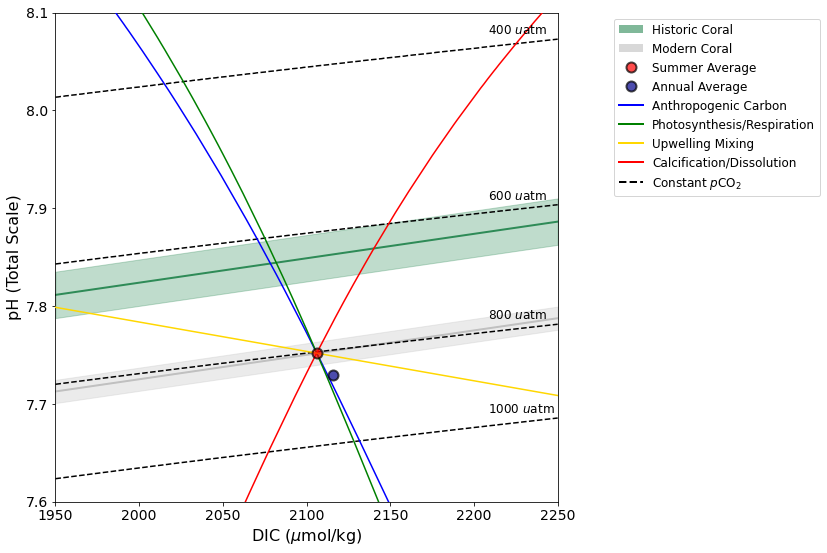

In [38]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)

ax.plot(DIC_range, pH_ranges_hist['pH_range']-offset, color = 'seagreen', linewidth=2, label = 'Historic', zorder = 0)
ax.plot(DIC_range, pH_ranges_mod['pH_range']-offset, color = 'silver', linewidth=2, label = 'Modern', zorder = 0)

ax.fill_between(DIC_range, (pH_ranges_hist['pH_range_low']-offset).values.astype(np.float64),
                (pH_ranges_hist['pH_range_high']-offset).values.astype(np.float64), color = 'seagreen', alpha = 0.3, zorder = 0)
ax.fill_between(DIC_range, (pH_ranges_mod['pH_range_low']-offset).values.astype(np.float64),
                (pH_ranges_mod['pH_range_high']-offset).values.astype(np.float64), color = 'silver', alpha = 0.3, zorder = 0)


ax.scatter(seasonal_avgs['DIC_avg'], seasonal_avgs['pH_avg'], label = 'Summer Average', s = 100,
           linewidth=2, facecolors='red', alpha = 0.7, edgecolors='black', zorder = 10)
ax.scatter(annual_avg_DIC, annual_avg_ph, label = 'Annual Average', s = 100,
           linewidth=2, facecolors='darkblue', alpha = 0.7, edgecolor='black', zorder = 10)


for pCO2 in pCO2_range:
    ax.plot(DIC_range, pH_calc_tot[pCO2], color = 'k', linestyle='--')
    label = str(pCO2)+' $u$atm' 
    ax.annotate(label, xy = (2250, pH_calc_tot[pCO2].iloc[-1]), xytext=(-70, 5),textcoords='offset points',
                        size = 12, zorder = 20)

ax.plot(pH_calc_invasion.index, pH_calc_invasion['pH_calc_tot'], label = 'Calculated pH, CO2 Invasion', color = 'blue', zorder = 5)
ax.plot(pH_calc_respiration.index, pH_calc_respiration['pH_calc_tot'], label = 'Calculated pH, Respiration', color = 'green', zorder = 5)
ax.plot(pH_calc_calcification.index, pH_calc_calcification['pH_calc_tot'], label = 'Calculated pH, Calcification', color = 'red', zorder = 5)
ax.plot(DIC_range, m_mix*DIC_range + b_mix, label = 'Calculated pH, Upwelling', color = 'gold', zorder = 5)    
    
ax.legend(prop={'size': legend_size}, bbox_to_anchor=(1.1, 1), handles = legend_elements)
ax.set_xlabel('DIC ($\mu$mol/kg)', size = axis_size)
ax.set_ylabel('pH (Total Scale)', size = axis_size)
plt.xticks(size = tick_size)
plt.yticks(size = tick_size)
ax.set_ylim(7.6, 8.1)
ax.set_xlim(1950, 2250)